<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,scipy,pandas,sklearn,mlxtend

last updated: 2017-03-22 

CPython 2.7.10
IPython 5.3.0

numpy 1.12.0
scipy 0.15.1
pandas 0.19.2
sklearn 0.18.1
mlxtend 0.5.1


# Data-MC comparison
### Table of contents
1. [Data preprocessing](#Data-preprocessing)
2. [Weight simulation events to spectrum](#Weight-simulation-events-to-spectrum)
3. [S125 verification](#S125-verification)
4. [$\log_{10}(\mathrm{dE/dX})$ verification](#$\log_{10}(\mathrm{dE/dX})$-verification)

In [ ]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from icecube.weighting.weighting import from_simprod

import composition as comp
import composition.analysis.plotting as plotting

color_dict = comp.analysis.get_color_dict()

%matplotlib inline

# Data preprocessing
[ [back to top](#top) ]
1. Load simulation/data dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets
4. Feature selection

### Load simulation, format feature and target matrices

In [ ]:
df_sim = comp.load_dataframe(datatype='sim', config='IC79')
df_data = comp.load_dataframe(datatype='data', config='IC79')

n_sim = len(df_sim)
n_data = len(df_data)
print('{} simulation events'.format(n_sim))
print('{} data events'.format(n_data))

In [ ]:
df_data = df_data[np.isfinite(df_data['log_dEdX'])]

# Weight simulation events to spectrum 

[ [back to top](#top) ]

For more information, see the [IT73-IC79 Data-MC comparison wiki page](https://wiki.icecube.wisc.edu/index.php/IT73-IC79_Data-MC_Comparison).

First, we'll need to define a 'realistic' flux model

In [ ]:
phi_0 = 2.95e-6
gamma_1 = -2.7
gamma_2 = -3.1
eps = 100
def flux(E):
    E = np.array(E) * 1e-6 
    return (1e-6) * phi_0 * E**gamma_1 *(1+(E/3.)**eps)**((gamma_2-gamma_1)/eps)

In [ ]:
from icecube.weighting.fluxes import GaisserH3a, GaisserH4a, Hoerandel5
flux_h4a = GaisserH4a()

In [ ]:
energy_points = np.logspace(6.0, 9.0, 100)
fig, ax = plt.subplots()
ax.plot(np.log10(energy_points), energy_points**2.7*flux_h4a(energy_points, 2212),
       marker='None', ls='-', lw=2, label='H4a proton')
ax.plot(np.log10(energy_points), energy_points**2.7*flux_h4a(energy_points, 1000260560),
       marker='None', ls='-', lw=2, label='H4a iron')
ax.plot(np.log10(energy_points), energy_points**2.7*flux(energy_points),
       marker='None', ls='-', lw=2, label='Simple knee')
ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\log_{10}(E/\mathrm{GeV})$')
ax.set_ylabel('$\mathrm{E}^{2.7} \ J(E) \ [\mathrm{GeV}^{1.7} \mathrm{m}^{-2} \mathrm{sr}^{-1} \mathrm{s}^{-1}]$')
ax.grid()
ax.legend()
plt.show()

In [ ]:
simlist = np.unique(df_sim['sim'])
for i, sim in enumerate(simlist):
    gcd_file, sim_files = comp.simfunctions.get_level3_sim_files(sim)
    num_files = len(sim_files)
    print('Simulation set {}: {} files'.format(sim, num_files))
    if i == 0:
        generator = num_files*from_simprod(int(sim))
    else:
        generator += num_files*from_simprod(int(sim))
energy = df_sim['MC_energy'].values
ptype = df_sim['MC_type'].values
num_ptypes = np.unique(ptype).size
cos_theta = np.cos(df_sim['MC_zenith']).values
weights = 1.0/generator(energy, ptype, cos_theta)
# weights = weights*num_ptypes

In [ ]:
# df_sim['weights'] = flux(df_sim['MC_energy'])*weights
df_sim['weights'] = flux_h4a(df_sim['MC_energy'], df_sim['MC_type'])*weights

In [ ]:
livetime = 27114012.
# livetime = 310.2 * (60*60*24)
print(livetime)

In [ ]:
# comp_list = ['light', 'heavy']
comp_list = ['P', 'Fe']
MC_comp_mask = {}
for composition in comp_list:
    MC_comp_mask[composition] = df_sim['MC_comp'] == composition
#     MC_comp_mask[composition] = df_sim['MC_comp_class'] == composition

In [ ]:
def plot_rate(array, weights, bins, xlabel=None, color='C0', label=None, legend=True, ax=None):
    
    if ax is None:
        ax = plt.gca()

    rate = np.histogram(array, bins=bins, weights=weights)[0]
    rate_err = np.sqrt(np.histogram(array, bins=bins, weights=weights**2)[0])
    plotting.plot_steps(bins, rate, yerr=rate_err, color=color,
                        label=label, ax=ax)
    ax.set_yscale('log', nonposy='clip')
    ax.set_ylabel('Rate [Hz]')
    if xlabel:
        ax.set_xlabel(xlabel)
    if legend:
        ax.legend()
    ax.grid(True)
    
    return ax

In [ ]:
def plot_data_MC_ratio(sim_array, sim_weights, data_array, data_weights, bins,
                       xlabel=None, color='C0', label=None, legend=False, ylim=None, ax=None):
    
    if ax is None:
        ax = plt.gca()

    sim_rate = np.histogram(sim_array, bins=bins, weights=sim_weights)[0]
    sim_rate_err = np.sqrt(np.histogram(sim_array, bins=bins, weights=sim_weights**2)[0])
    
    data_rate = np.histogram(data_array, bins=bins, weights=data_weights)[0]
    data_rate_err = np.sqrt(np.histogram(data_array, bins=bins, weights=data_weights**2)[0])
    
    ratio, ratio_err = comp.analysis.ratio_error(data_rate, data_rate_err, sim_rate, sim_rate_err)
    
    plotting.plot_steps(bins, ratio, yerr=ratio_err,
                        color=color, label=label, ax=ax)
    ax.grid(True)
    ax.set_ylabel('Data/MC')
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylim:
        ax.set_ylim(ylim)
    if legend:
        ax.legend()

    ax.axhline(1, marker='None', ls='-.', color='k')
    
    return ax

## $\log_{10}(\mathrm{S_{125}})$ verification

[ [back to top](#top) ]

In [ ]:
df_sim['log_s125'].plot(kind='hist', bins=100)

In [ ]:
log_s125_bins = np.linspace(-2, 4, 75)

gs = gridspec.GridSpec(2, 1, height_ratios=[2,1], hspace=0.0)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)
for composition in comp_list:
    sim_s125 = df_sim[MC_comp_mask[composition]]['log_s125']
    sim_weights = df_sim[MC_comp_mask[composition]]['weights']
    plot_rate(sim_s125, sim_weights, bins=log_s125_bins,
              color=color_dict[composition], label=composition, ax=ax1)
data_weights = np.array([1/livetime]*len(df_data['log_s125']))
plot_rate(df_data['log_s125'], data_weights, bins=log_s125_bins,
          color=color_dict['data'], label='data', ax=ax1)

for composition in comp_list:
    sim_s125 = df_sim[MC_comp_mask[composition]]['log_s125']
    sim_weights = df_sim[MC_comp_mask[composition]]['weights']
    ax2 = plot_data_MC_ratio(sim_s125, sim_weights, 
                       df_data['log_s125'], data_weights, log_s125_bins,
                       xlabel='$\log_{10}(\mathrm{S}_{125})$', color=color_dict[composition],
                       label=composition, ax=ax2)

plt.savefig('/home/jbourbeau/public_html/figures/data-MC-comparison-s125.png')
plt.show()

##  $\log_{10}(\mathrm{dE/dX})$ verification

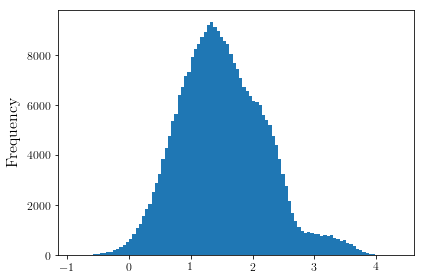

In [153]:
df_sim['log_dEdX'].plot(kind='hist', bins=100)

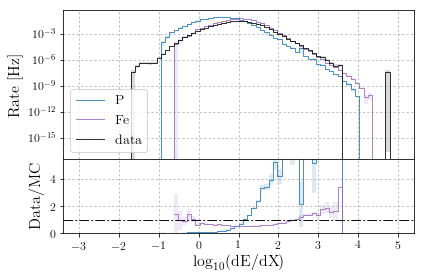

In [233]:
log_dEdX_bins = np.linspace(-3, 5, 75)

gs = gridspec.GridSpec(2, 1, height_ratios=[2,1], hspace=0.0)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)
for composition in comp_list:
    sim_dEdX = df_sim[MC_comp_mask[composition]]['log_dEdX']
    sim_weights = df_sim[MC_comp_mask[composition]]['weights']
    plot_rate(sim_dEdX, sim_weights, bins=log_dEdX_bins,
              color=color_dict[composition], label=composition, ax=ax1)
data_weights = np.array([1/livetime]*len(df_data))
plot_rate(df_data['log_dEdX'], data_weights, bins=log_dEdX_bins,
          color=color_dict['data'], label='data', ax=ax1)

for composition in comp_list:
    sim_dEdX = df_sim[MC_comp_mask[composition]]['log_dEdX']
    sim_weights = df_sim[MC_comp_mask[composition]]['weights']
    ax2 = plot_data_MC_ratio(sim_dEdX, sim_weights,
                       df_data['log_dEdX'], data_weights, log_dEdX_bins,
                       xlabel='$\log_{10}(\mathrm{dE/dX})$', color=color_dict[composition],
                       label=composition, ylim=[0, 5.5], ax=ax2)

plt.savefig('/home/jbourbeau/public_html/figures/data-MC-comparison-dE_dX.png')
plt.show()

## $\cos(\theta)$ verification

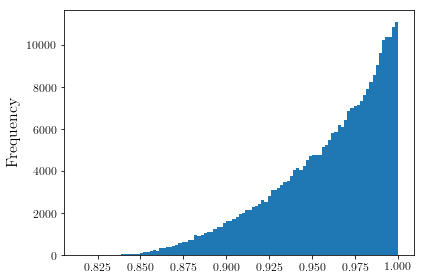

In [155]:
df_sim['lap_cos_zenith'].plot(kind='hist', bins=100)

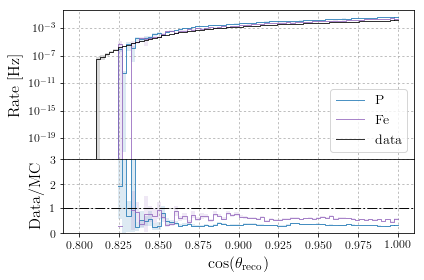

In [232]:
cos_zenith_bins = np.linspace(0.8, 1.0, 75)

gs = gridspec.GridSpec(2, 1, height_ratios=[2,1], hspace=0.0)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)
for composition in comp_list:
    sim_cos_zenith = df_sim[MC_comp_mask[composition]]['lap_cos_zenith']
    sim_weights = df_sim[MC_comp_mask[composition]]['weights']
    plot_rate(sim_cos_zenith, sim_weights, bins=cos_zenith_bins,
              color=color_dict[composition], label=composition, ax=ax1)
data_weights = np.array([1/livetime]*len(df_data))
plot_rate(df_data['lap_cos_zenith'], data_weights, bins=cos_zenith_bins,
          color=color_dict['data'], label='data', ax=ax1)

for composition in comp_list:
    sim_cos_zenith = df_sim[MC_comp_mask[composition]]['lap_cos_zenith']
    sim_weights = df_sim[MC_comp_mask[composition]]['weights']
    ax2 = plot_data_MC_ratio(sim_cos_zenith, sim_weights,
                       df_data['lap_cos_zenith'], data_weights, cos_zenith_bins,
                       xlabel='$\cos(\\theta_{\mathrm{reco}})$', color=color_dict[composition],
                       label=composition, ylim=[0, 3], ax=ax2)

plt.savefig('/home/jbourbeau/public_html/figures/data-MC-comparison-zenith.png')
plt.show()